<a href="https://colab.research.google.com/github/JordanDSIA/2025_UTEC_PROGRAMACION_101/blob/main/Practica%2002%20-%20IA%20Fundamental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importar Librerias

In [26]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from matplotlib import pyplot as plt
import time # Importar para medir el tiempo de ejecución

Parámetros del Problema, Nodos y Matriz de Distancias

In [27]:
N = 50       # Cantidad de CLIENTES
N_VEHICLES = 3 # Cantidad de vehículos

# Nodos Generados = N clientes + 1 depósito
positions = np.random.rand(N + 1, 2)

# Calcular la matriz de distancias entre todos los nodos
distances = squareform(pdist(positions, 'euclidean'))

print("Número de clientes:", N)
print("Número total de nodos (1 Deposito + Clientes):", N + 1)
print("Número de vehículos:", N_VEHICLES)
print("\nPosiciones de los nodos (Depósito en índice 0):")
print(positions[:5], "...")
print("\nMatriz de distancias:")
print(distances[:5, :5], "...")

Número de clientes: 50
Número total de nodos (1 Deposito + Clientes): 51
Número de vehículos: 3

Posiciones de los nodos (Depósito en índice 0):
[[0.51418262 0.18505333]
 [0.25850251 0.60284277]
 [0.50879751 0.16123729]
 [0.55192529 0.53625556]
 [0.29712087 0.13408886]] ...

Matriz de distancias:
[[0.         0.48981663 0.02441727 0.35322446 0.22296452]
 [0.48981663 0.         0.50760515 0.30088334 0.47034201]
 [0.02441727 0.50760515 0.         0.37749002 0.21341048]
 [0.35322446 0.30088334 0.37749002 0.         0.47609174]
 [0.22296452 0.47034201 0.21341048 0.47609174 0.        ]] ...


Fitness(Función Objetivo) , Generación de Vecinos y Aceptación

In [28]:
def fitness(sol):
    distance = 0
    for i in range(len(sol) - 1):
        distance += distances[sol[i]][sol[i+1]]
    # Para VRP con depósitos explícitos en la ruta, distances[sol[-1]][sol[0]] y distances[0][0] que es 0.
    distance += distances[sol[-1]][sol[0]]
    return distance

def get_neighbors(sol):
    neighbors = []
    num_elements = len(sol) # Longitud de la secuencia VRP (clientes + depósitos)
    for i in range(num_elements - 1):
        for j in range(i + 1, num_elements):
            new_sol = sol.copy()
            new_sol[i], new_sol[j] = new_sol[j], new_sol[i]
            neighbors.append(new_sol)
    return neighbors

def random_neighbor(sol):
    num_elements = len(sol) # Longitud de la secuencia VRP (clientes + depósitos)
    i, j = np.random.choice(num_elements, 2, replace=False)
    new_sol = sol.copy()
    new_sol[i], new_sol[j] = new_sol[j], new_sol[i]
    return new_sol

def accept(delta, T):
    if delta < 0:
        return True
    else:
        r = np.random.rand()
        return r < np.exp(-delta/T)

Algoritmos de Búsqueda Local

In [29]:
def hill_climbing(initial_solution):
    current_solution = initial_solution.copy()
    while True:
        neighbors = get_neighbors(current_solution)
        best_neighbor = min(neighbors, key=fitness)
        if fitness(best_neighbor) < fitness(current_solution):
            current_solution = best_neighbor
        else:
            return current_solution

def simulated_annealing(T_max, T_min, cooling_rate, initial_solution):
    T = T_max
    x = initial_solution.copy()
    E = fitness(x)
    while (T > T_min):
        x_new = random_neighbor(x)
        E_new = fitness(x_new)
        delta = E_new - E
        if accept(delta, T):
            x = x_new
            E = E_new
        T = T * cooling_rate
    return x

Función de Ploteo

In [30]:
def plot_tsp(nodes_coords, route, title="Ruta VRP"):
    plt.figure(figsize=(8, 6))

    plt.scatter(nodes_coords[1:, 0], nodes_coords[1:, 1], color='blue', zorder=2, s=50, label='Clientes')
    plt.scatter(nodes_coords[0, 0], nodes_coords[0, 1], color='red', marker='s', s=150, zorder=3, label='Depósito (0)')

    for i in range(1, len(nodes_coords)):
        plt.annotate(str(i), (nodes_coords[i][0] + 0.02, nodes_coords[i][1] + 0.02), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate("0", (nodes_coords[0][0] + 0.02, nodes_coords[0][1] + 0.02), textcoords="offset points", xytext=(0,10), ha='center', color='red')

    route_colors = plt.cm.get_cmap('viridis', N_VEHICLES + 2) # Más colores para asegurar distinción

    current_segment_start_node_idx = 0
    vehicle_counter = 0

    # Iterar sobre la ruta para dibujar segmentos
    for i in range(len(route) - 1):
        node1_in_route = route[i]
        node2_in_route = route[i+1]

        # Dibuja la línea entre el nodo actual y el siguiente
        plt.plot([nodes_coords[node1_in_route][0], nodes_coords[node2_in_route][0]],
                 [nodes_coords[node1_in_route][1], nodes_coords[node2_in_route][1]],
                 color=route_colors(vehicle_counter % N_VEHICLES), linewidth=2, alpha=0.7, zorder=1)

        # Si el siguiente nodo es un depósito (0) y no es el final de la secuencia completa, significa que esta ruta de vehículo termina.
        if node2_in_route == 0 and (i + 1 < len(route) - 1):
            vehicle_counter += 1 # Incrementar el contador de vehículos para el próximo color

    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

Ejecución Principal y Comparación


--- Solución Inicial (VRP) ---
Ruta inicial: [ 0 34 11 17 25 19 30 23 38 44 48  4  1 24 20  6 14 42 33 32 12 15  9 22
  7 37 29 36 40 46  8 26 50 13  0 49 41 10  0  3 43  2 18 31 21 27  5 35
 45 39 28 16 47  0]
Fitness inicial: 25.440843849572882


<ipython-input-30-4e4061c60ce2>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  route_colors = plt.cm.get_cmap('viridis', N_VEHICLES + 2) # Más colores para asegurar distinción


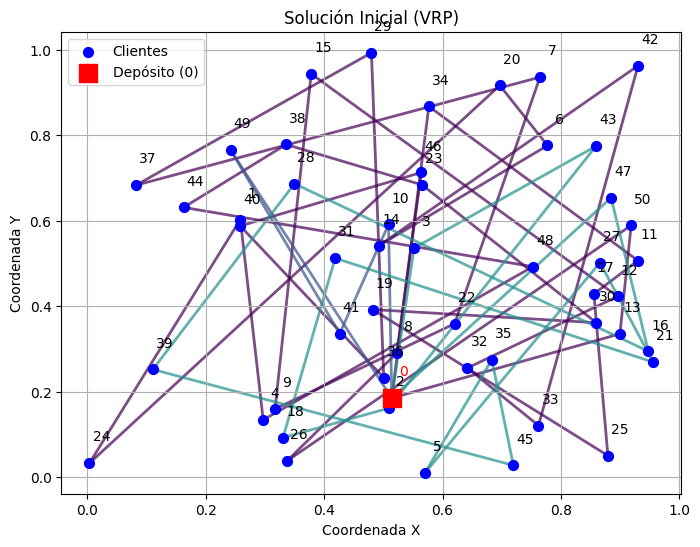


--- Ejecutando Hill Climbing ---
Solución Hill Climbing: [48 30 13 12 11 50 47 38 28 44 37 49 15 29 34  6 27 17 33  5 26 18  9  4
 24 39 40  1 10 14  3 22 35 32  8 19 31 41 36  0  0  0  0  2 45 25 21 16
 43 42  7 20 46 23]
Fitness Hill Climbing: 8.213955525253885
Tiempo de ejecución Hill Climbing: 3.2471 segundos


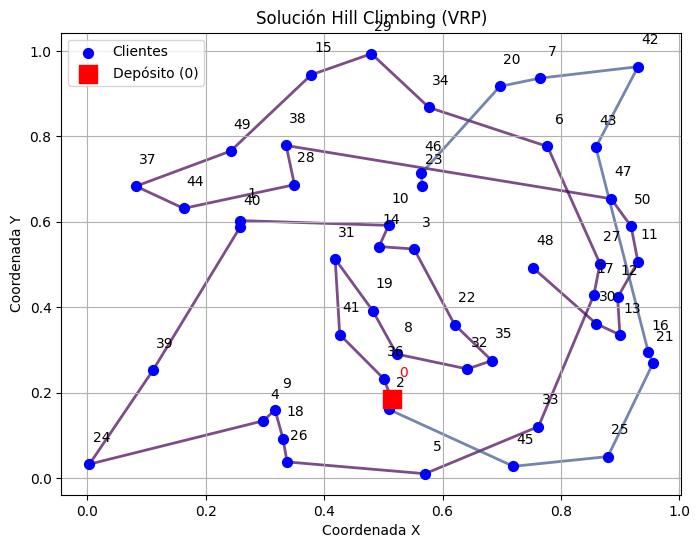


--- Ejecutando Simulated Annealing ---
Solución Simulated Annealing: [ 4 18 26  0  0  0  0  2  5 45 33 25 21 16 13 42  7 20 34 29 15 46 23  6
 43 47 50 11 27 48  3 40  1 44 37 49 38 28 10 14 31 41 19 22 17 12 30 35
 32  8 36  9 39 24]
Fitness Simulated Annealing: 7.1598456777494635
Tiempo de ejecución Simulated Annealing: 20.1601 segundos


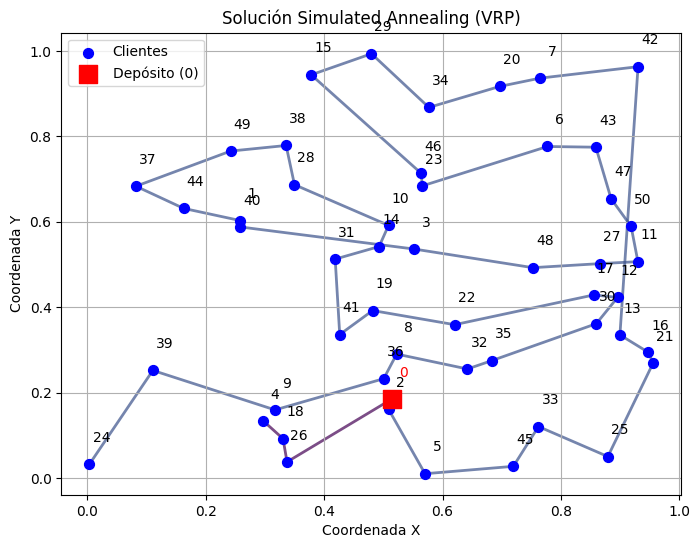

In [31]:
# Generar la solución inicial para VRP
# Contendrá N clientes (1 a N) y (N_VEHICLES + 1) veces el depósito (0)
# Longitud total de la secuencia: N + N_VEHICLES + 1
vrp_elements = list(range(1, N + 1)) + [0] * (N_VEHICLES + 1)
np.random.shuffle(vrp_elements)

# Asegurarse que la solución inicial empiece y termine con el depósito (0)
current_vrp_elements = list(vrp_elements)

# Mover un '0' al principio
if current_vrp_elements[0] != 0:
    first_zero_idx = current_vrp_elements.index(0)
    current_vrp_elements[0], current_vrp_elements[first_zero_idx] = current_vrp_elements[first_zero_idx], current_vrp_elements[0]

# Mover otro '0' al final
if current_vrp_elements[-1] != 0:
    last_zero_found_idx = -1
    for k in range(len(current_vrp_elements) - 2, -1, -1): # Recorre desde el final hacia el principio (evitando el primer elemento)
        if current_vrp_elements[k] == 0:
            last_zero_found_idx = k
            break
    if last_zero_found_idx != -1:
        current_vrp_elements[-1], current_vrp_elements[last_zero_found_idx] = current_vrp_elements[last_zero_found_idx], current_vrp_elements[-1]
    # else: No es estrictamente necesario, ya que la longitud con N_VEHICLES + 1 ceros garantiza al menos 2 ceros
    # si N_VEHICLES >= 1.

initial_solution = np.array(current_vrp_elements)

print("\n--- Solución Inicial (VRP) ---")
print("Ruta inicial:", initial_solution)
print("Fitness inicial:", fitness(initial_solution))
plot_tsp(positions, initial_solution, "Solución Inicial (VRP)")


# Parámetros para Simulated Annealing
T_max = 1000
T_min = 0.000001
cooling_rate = 0.9999

# Ejecutar Hill Climbing
print("\n--- Ejecutando Hill Climbing ---")
start_time_hc = time.time()
sol1 = hill_climbing(initial_solution)
end_time_hc = time.time()
time_hc = end_time_hc - start_time_hc

print("Solución Hill Climbing:", sol1)
fitness_hc = fitness(sol1)
print("Fitness Hill Climbing:", fitness_hc)
print("Tiempo de ejecución Hill Climbing: {:.4f} segundos".format(time_hc))
plot_tsp(positions, sol1, "Solución Hill Climbing (VRP)")

# Ejecutar Simulated Annealing
print("\n--- Ejecutando Simulated Annealing ---")
start_time_sa = time.time()
sol2 = simulated_annealing(T_max, T_min, cooling_rate, initial_solution)
end_time_sa = time.time()
time_sa = end_time_sa - start_time_sa

print("Solución Simulated Annealing:", sol2)
fitness_sa = fitness(sol2)
print("Fitness Simulated Annealing:", fitness_sa)
print("Tiempo de ejecución Simulated Annealing: {:.4f} segundos".format(time_sa))
plot_tsp(positions, sol2, "Solución Simulated Annealing (VRP)")

Resumen de Resultados

In [19]:
print("\n--- Resumen de Resultados ---")
print("Fitness Inicial:", fitness(initial_solution))
print("Hill Climbing - Fitness: {:.2f}, Tiempo: {:.4f}s".format(fitness_hc, time_hc))
print("Simulated Annealing - Fitness: {:.2f}, Tiempo: {:.4f}s".format(fitness_sa, time_sa))


--- Resumen de Resultados ---
Fitness Inicial: 4.445669344018992
Hill Climbing - Fitness: 2.55, Tiempo: 0.0025s
Simulated Annealing - Fitness: 2.55, Tiempo: 9.1322s
